In [2]:
import sys
import rootpy.ROOT as ROOT
import numpy as np


Welcome to JupyROOT 6.18/00


In [3]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [4]:
# import warnings
# warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

DEBUG:matplotlib] CONFIGDIR=/home/jack/.config/matplotlib
DEBUG:matplotlib] matplotlib data path: /home/jack/.virtualenvs/BNN_env_python3.6/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib] loaded rc file /home/jack/.virtualenvs/BNN_env_python3.6/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib] matplotlib version 3.1.0
DEBUG:matplotlib] interactive is False
DEBUG:matplotlib] platform is linux
DEBUG:matplotlib] loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyw

DEBUG:matplotlib] CACHEDIR=/home/jack/.cache/matplotlib
DEBUG:matplotlib.font_manager] Using fontManager instance from /home/jack/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot] Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [5]:
ROOT.gSystem.Load("libDelphes")
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

inputFile = '/home/jack/projects/monosquark/data/tag_2_delphes_events.root'
chain = ROOT.TChain("Delphes")
chain.Add(inputFile)
treeReader = ROOT.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

ERROR:ROOT.TInterpreter.AutoParse] Error parsing payload code for class ExRootTreeReader with content:

#line 1 "ExRootAnalysisDict dictionary payload"


#define _BACKWARD_BACKWARD_WARNING_H
// Inline headers

/** \class ExRootAnalysisLinkDef
 *
 *  Lists classes to be included in cint dicitonary
 *
 *  \author P. Demin - UCL, Louvain-la-Neuve
 *
 */

#include "ExRootAnalysis/ExRootTreeReader.h"
#include "ExRootAnalysis/ExRootTreeWriter.h"
#include "ExRootAnalysis/ExRootTreeBranch.h"
#include "ExRootAnalysis/ExRootResult.h"
#include "ExRootAnalysis/ExRootUtilities.h"
#include "ExRootAnalysis/ExRootClassifier.h"
#include "ExRootAnalysis/ExRootFilter.h"

#include "ExRootAnalysis/ExRootProgressBar.h"
#include "ExRootAnalysis/ExRootConfReader.h"
#include "ExRootAnalysis/ExRootTask.h"

#ifdef __CINT__

#pragma link off all globals;
#pragma link off all classes;
#pragma link off all functions;

#pragma link C++ class ExRootTreeReader+;
#pragma link C++ class ExRootTreeBranch+;
#pragma link C

In [8]:
branchParticle = treeReader.UseBranch("Particle")
branchFatJet = treeReader.UseBranch("FatJet")
branchJet = treeReader.UseBranch("Jet")
branchEFlowTrack = treeReader.UseBranch("EFlowTrack")
branchEFlowECal = treeReader.UseBranch("EFlowPhoton")
branchEFlowHCal = treeReader.UseBranch("EFlowNeutralHadron")

branchMuon = treeReader.UseBranch("Muon")
branchElectron = treeReader.UseBranch("Electron")

treeReader.ReadEntry(0)

True

** WARNING: branch 'Particle' is already in use
** WARNING: branch 'Jet' is already in use
** WARNING: branch 'EFlowTrack' is already in use
** WARNING: branch 'EFlowPhoton' is already in use
** WARNING: branch 'EFlowNeutralHadron' is already in use
** WARNING: branch 'Muon' is already in use
** WARNING: branch 'Electron' is already in use


In [9]:
import pyjet
from pyjet import PseudoJet

In [109]:
def pTof(obj):
    if isinstance(obj,ROOT.Track):
        return obj.PT
    elif isinstance(obj,ROOT.Muon):
        return obj.PT
    elif isinstance(obj,ROOT.Electron):
        return obj.PT
    elif isinstance(obj,ROOT.Photon):
        return obj.PT
    elif isinstance(obj,ROOT.Tower):
        return obj.ET
    else:
        raise

num_IDs = 6
def pTetaphiIDof(obj):
    part_ID = 0
    if isinstance(obj,ROOT.Tower):
        if obj.Ehad > obj.Eem:
            part_ID = 0
        else:
            part_ID = 1
    elif isinstance(obj,ROOT.Track):
        part_ID = 2
    elif isinstance(obj,ROOT.Muon):
        part_ID = 3
    elif isinstance(obj,ROOT.Electron):
        part_ID = 4
    elif isinstance(obj,ROOT.Photon):
        part_ID = 5
        
    part_ID_onehot = np.zeros(6)
    part_ID_onehot[part_ID] = 1
        
        
    try:    
        return np.append(np.array([pTof(obj),obj.Eta,obj.Phi]),
                         part_ID_onehot)
    except:
        raise

In [118]:
numevents = treeReader.GetEntries()
pts = []
numparticles = []
eta = []
numpass = 0


for event_i in range(numevents):

    treeReader.ReadEntry(event_i)

    numjets = branchFatJet.GetEntriesFast()
    if numjets == 0:
        continue
    jet = branchFatJet.At(0)
    #pts.append(jet.PT)
    #constituents = jet.Constituents
    #numparticles.append(constituents.GetEntriesFast())
    if jet.PT >= 500:
        numpass += 1

print("Number of jets: ", numpass, " from ", numevents, " events.")
jets_np = np.zeros((numpass,200,3+num_IDs))

index = 0

try:
    for event_i in range(numevents):
        if event_i%1000 is 0:
            print("Working on event", event_i)
        treeReader.ReadEntry(event_i)
        numjets = branchFatJet.GetEntriesFast()
        if numjets == 0:
            continue
        jet = branchFatJet.At(0)

        if jet.PT < 500:
            continue

        constituents = jet.Constituents
        particles_np = np.zeros((200,3+num_IDs))
        
        for j, particle in enumerate(constituents):
            particles_np[j] = pTetaphiIDof(particle)
            order = np.flip(np.argsort(particles_np[:,0]))
            particles_np = particles_np[order]

        jets_np[index] = particles_np
        index += 1
except:
    print("\n\nFailed to identify particle.")
    print("Event", event_i)
    print("Particle", j)

Number of jets:  96639  from  100000  events.
Working on event 0


ERROR:ROOT.TInterpreter.AutoParse] Error parsing payload code for class Electron with content:

#line 1 "ClassesDict dictionary payload"


#define _BACKWARD_BACKWARD_WARNING_H
// Inline headers
/*
 *  Delphes: a framework for fast simulation of a generic collider experiment
 *  Copyright (C) 2012-2014  Universite catholique de Louvain (UCL), Belgium
 *
 *  This program is free software: you can redistribute it and/or modify
 *  it under the terms of the GNU General Public License as published by
 *  the Free Software Foundation, either version 3 of the License, or
 *  (at your option) any later version.
 *
 *  This program is distributed in the hope that it will be useful,
 *  but WITHOUT ANY WARRANTY; without even the implied warranty of
 *  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 *  GNU General Public License for more details.
 *
 *  You should have received a copy of the GNU General Public License
 *  along with this program.  If not, see <http://www.gnu.org/l

Working on event 1000
Working on event 2000
Working on event 3000
Working on event 4000
Working on event 5000
Working on event 6000
Working on event 7000
Working on event 8000
Working on event 9000
Working on event 10000
Working on event 11000
Working on event 12000
Working on event 13000
Working on event 14000
Working on event 15000
Working on event 16000
Working on event 17000
Working on event 18000
Working on event 19000
Working on event 20000
Working on event 21000
Working on event 22000
Working on event 23000
Working on event 24000
Working on event 25000
Working on event 26000
Working on event 27000
Working on event 28000
Working on event 29000
Working on event 30000
Working on event 31000
Working on event 32000
Working on event 33000
Working on event 34000
Working on event 35000
Working on event 36000
Working on event 37000
Working on event 38000
Working on event 39000
Working on event 40000
Working on event 41000
Working on event 42000
Working on event 43000
Working on event 440

In file included from ClassesDict dictionary payload:32:
/home/jack/MG5_aMC_v2_6_6/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from ClassesDict dictionary payload:32:
/home/jack/MG5_aMC_v2_6_6/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [126]:
np.save("jets_np_test.npy", jets_np)

In [117]:
pTetaphiIDof(constituents.At(0))

array([ 1.48985791, -0.4855282 , -1.77718973,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ])

In [107]:
constituents.At(35)

<ROOT.Muon object ("Muon") at 0x7023450>

In [94]:
jets_np

array([[[358.03295898,  -1.88821757,  -1.11192226,   2.        ],
        [ 94.61406708,  -1.88220084,  -1.10879433,   2.        ],
        [ 92.43204498,  -1.88146472,  -1.10790658,   2.        ],
        ...,
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[358.03295898,  -1.88821757,  -1.11192226,   2.        ],
        [ 94.61406708,  -1.88220084,  -1.10879433,   2.        ],
        [ 92.43204498,  -1.88146472,  -1.10790658,   2.        ],
        ...,
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]]])

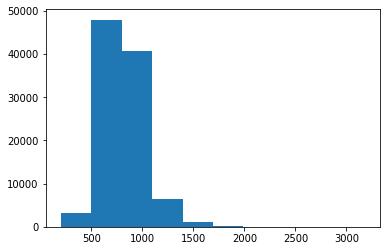

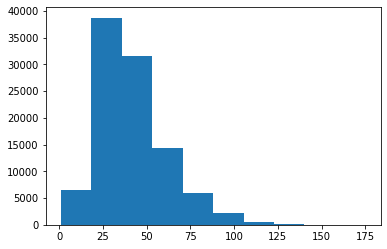

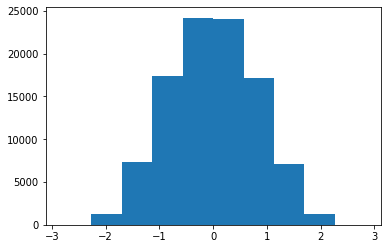

In [73]:
import matplotlib.pyplot as plt
plt.hist(pts)
plt.show()
plt.hist(numparticles)
plt.show()
plt.hist(eta)
plt.show()

In [48]:
for i in range(20):
    print(pTof(constituents.At(i)))

0.3469005525112152
0.22310522198677063
1.4249409437179565
1.184728980064392
1.602723240852356
1.7216546535491943
1.4249117374420166
0.3958585560321808
1.3613107204437256
5.589325428009033
2.752147912979126
5.25909948348999
0.6921219229698181
6.302548408508301
11.41144847869873
0.6478815674781799
5.832676410675049
5.445045471191406
8.809860229492188
18.353389739990234


In [64]:
for i in range(constituents.GetEntriesFast()):
    particle = constituents.At(i)
    if isinstance(particle,ROOT.Track):
        print(particle.D0)

0.0
-0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-33.496253967285156
-0.0
-0.0
-0.0
-0.0
-0.0


In [54]:
particle.Eem

0.0

In [47]:

pTof(constituents.At(0))


0.3469005525112152

In [7]:
num_with_lepton = 0
numevents = 10000
num_with_lepton_cut1 = 0

max_lepton_pt = []

numjets_list = []

for event_i in range(numevents):
    treeReader.ReadEntry(event_i)
    if branchElectron.GetEntriesFast() + branchMuon.GetEntriesFast() > 0:
        num_with_lepton += 1
        
        lepton_pts = []
        for j in range(branchElectron.GetEntriesFast()):
            lepton_pts.append(branchElectron.At(j).PT)
        for j in range(branchMuon.GetEntriesFast()):
            lepton_pts.append(branchMuon.At(j).PT)

        max_lepton_pt.append(np.max(lepton_pts))
        if np.max(lepton_pts) > 25:
            num_with_lepton_cut1 += 1
            
        numjets_list.append(branchJet.GetEntriesFast())
print(1.*num_with_lepton/numevents)
print(1.*num_with_lepton_cut1/numevents)

ERROR:ROOT.TInterpreter.AutoParse] Error parsing payload code for class Electron with content:

#line 1 "ClassesDict dictionary payload"


#define _BACKWARD_BACKWARD_WARNING_H
// Inline headers
/*
 *  Delphes: a framework for fast simulation of a generic collider experiment
 *  Copyright (C) 2012-2014  Universite catholique de Louvain (UCL), Belgium
 *
 *  This program is free software: you can redistribute it and/or modify
 *  it under the terms of the GNU General Public License as published by
 *  the Free Software Foundation, either version 3 of the License, or
 *  (at your option) any later version.
 *
 *  This program is distributed in the hope that it will be useful,
 *  but WITHOUT ANY WARRANTY; without even the implied warranty of
 *  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 *  GNU General Public License for more details.
 *
 *  You should have received a copy of the GNU General Public License
 *  along with this program.  If not, see <http://www.gnu.org/l

0.3049
0.2748


In file included from ClassesDict dictionary payload:32:
/home/jack/MG5_aMC_v2_6_6/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from ClassesDict dictionary payload:32:
/home/jack/MG5_aMC_v2_6_6/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from ClassesDict dictionary payload:32:
/home/jack/MG5_aMC_v2_6_6/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~


DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager] findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager] findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
DEBUG

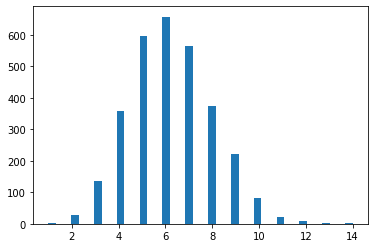

In [8]:
plt.hist(numjets_list,bins=40)
#plt.semilogy(nonposy="clip")
plt.show()

In [25]:
branchElectron

<ROOT.TClonesArray object ("Electron") at 0x7d46330>

In [40]:
np.arange(1000022,1000100)

array([1000022, 1000023, 1000024, 1000025, 1000026, 1000027, 1000028,
       1000029, 1000030, 1000031, 1000032, 1000033, 1000034, 1000035,
       1000036, 1000037, 1000038, 1000039, 1000040, 1000041, 1000042,
       1000043, 1000044, 1000045, 1000046, 1000047, 1000048, 1000049,
       1000050, 1000051, 1000052, 1000053, 1000054, 1000055, 1000056,
       1000057, 1000058, 1000059, 1000060, 1000061, 1000062, 1000063,
       1000064, 1000065, 1000066, 1000067, 1000068, 1000069, 1000070,
       1000071, 1000072, 1000073, 1000074, 1000075, 1000076, 1000077,
       1000078, 1000079, 1000080, 1000081, 1000082, 1000083, 1000084,
       1000085, 1000086, 1000087, 1000088, 1000089, 1000090, 1000091,
       1000092, 1000093, 1000094, 1000095, 1000096, 1000097, 1000098,
       1000099])

In [26]:
for i in range(100):
    print(i,branchParticle.At(i).PID,branchParticle.At(i).Status,branchParticle.At(i).D1)

0 21 21 3
1 21 43 15
2 2 21 3
3 1000001 22 8
4 1000037 22 9
5 21 41 0
6 21 43 22
7 2 42 2
8 1000001 44 13
9 1000037 44 14
10 21 41 5
11 2 42 7
12 21 43 53
13 1000001 44 19
14 1000037 44 20
15 21 44 21
16 21 42 10
17 2 41 11
18 21 43 69
19 1000001 44 49
20 1000037 44 50
21 21 44 51
22 21 44 52
23 -3 31 26
24 21 43 38
25 21 31 26
26 -3 33 31
27 21 33 32
28 -3 41 23
29 3 43 45
30 21 42 25
31 -3 44 36
32 21 44 37
33 21 41 28
34 21 42 30
35 1 43 60
36 -3 44 42
37 21 44 43
38 21 44 44
39 21 42 33
40 -2 43 133
41 1 41 34
42 -3 44 56
43 21 44 57
44 21 44 58
45 3 44 59
46 21 42 16
47 2 43 96
48 2 41 17
49 1000001 44 64
50 1000037 44 65
51 21 44 66
52 21 44 67
53 21 44 68
54 -2 41 39
55 1 42 41
56 -3 44 128
57 21 44 129
58 21 44 130
59 3 44 131
60 1 44 132
61 2 41 46
62 2 42 48
63 21 43 127
64 1000001 44 90
65 1000037 44 91
66 21 44 92
67 21 44 93
68 21 44 94
69 21 44 95
70 1 31 73
71 21 31 73
72 21 43 136
73 1 33 81
74 21 33 82
75 -3 31 77
76 21 31 77
77 -3 33 137
78 21 33 138
79 1 42 70
80 21 

In [48]:
quarks = np.array([-6,-5,-4,-3,-2,-1,1,2,3,4,5,6])
inos = np.append(np.arange(1000022,1000100),np.arange(-1000100,-1000022))

def get_truth_particles():

    boosted_wino=0
    quark=0
    current_particle = branchParticle.At(3)
    associated_wino = branchParticle.At(4)
    while boosted_wino == 0:
        
#         if current_particle.D1 is -1:
#             boosted_wino = current_particle
        
        D1 = branchParticle.At(current_particle.D1)
        D2 = branchParticle.At(current_particle.D2)

        if np.any(D1.PID == quarks) and np.any(D2.PID == inos):
            quark = D1
            boosted_wino = D2
        elif np.any(D2.PID == quarks) and np.any(D1.PID == inos):
            quark = D2
            boosted_wino = D1
        elif np.any(D1.PID == quarks) or np.any(D2.PID == quarks) or np.any(D1.PID == inos) or np.any(D2.PID == inos):
            raise
        else:
            current_particle = D1
    
    return quark, boosted_wino, associated_wino

In [50]:
for event_i in range(50):
    treeReader.ReadEntry(event_i)
    try:
        quark, boosted_wino, associated_wino = get_truth_particles()
    except:
        #print("Fail")
        continue
    #print(event_i, quark.PID, boosted_wino.PID, associated_wino.PID)
    fat_jet

0 1 1000035 1000037
1 2 1000035 -1000037
2 1 1000035 1000037
3 2 -1000037 1000037
4 2 -1000037 1000037
5 1 1000035 1000037
6 1 1000037 -1000037
7 1 1000024 1000035
8 2 -1000037 1000037
9 2 1000035 1000035
10 1 1000024 -1000037
11 2 -1000037 1000037
Fail
13 2 1000035 -1000037
14 2 -1000037 1000037
Fail
16 2 -1000024 1000037
17 1 1000023 1000037
18 2 -1000037 1000037
19 1 1000037 -1000037
20 2 -1000037 1000037
21 1 1000037 1000035
22 1 1000024 1000035
Fail
24 1 1000023 1000037
25 2 -1000037 1000037
26 1 1000037 1000035
27 2 -1000024 1000037
28 1 1000024 1000035
29 1 1000035 1000035
30 2 -1000037 1000037
31 1 1000035 1000037
Fail
33 1 1000037 -1000037
34 1 1000022 1000037
35 2 1000023 1000035
36 2 1000035 -1000037
37 1 1000023 -1000037
38 1 1000035 1000037
39 2 -1000037 1000037
40 1 1000025 1000037
41 2 -1000037 1000035
42 2 -1000037 1000037
43 2 -1000037 1000037
44 2 -1000037 1000037
45 1 1000024 1000035
Fail
Fail
48 2 -1000024 1000037
49 1 1000023 1000037


In [ ]:
for event_i in range(10):
    treeReader.ReadEntry(event_i)
    quark, boosted_wino, associated_wino = get_truth_particles()
    if abs(boosted_wino.PID ) < 1000003:
        continue
    

In [7]:
num=114
particle=branchParticle.At(num)
print(num,particle.PID,particle.Status,particle.D1,particle.D2)

num=134
particle=branchParticle.At(num)
print(num,particle.PID,particle.Status,particle.D1,particle.D2,particle.M1,particle.M2)

num=136
particle=branchParticle.At(num)
print(num,particle.PID,particle.Status,particle.D1,particle.D2,particle.M1,particle.M2)

114 21 61 80 80
134 1 62 310 310 81 -1
136 21 62 429 429 72 -1


In [8]:
get_truth_particles()

(<ROOT.GenParticle object ("GenParticle") at 0x78a2640>,
 <ROOT.GenParticle object ("GenParticle") at 0x78a26c0>,
 <ROOT.GenParticle object ("GenParticle") at 0x783add0>)

In [9]:
def get_decay_products(particle):
    intermediate_particle = particle
    daughter1 = 0
    daughter2 = 0
    while daughter1 == 0:
        D1 = branchParticle.At(intermediate_particle.D1)
        D2 = branchParticle.At(intermediate_particle.D2)
        if D1.PID != particle.PID:
            daughter1 = D1
            daughter2 = D2
        else:
            intermediate_particle = D1
            
    return daughter1, daughter2

In [10]:
print(boosted_wino.PID,get_decay_products(boosted_wino)[1].PID)
print(quark.PID)

NameError: name 'boosted_wino' is not defined

In [12]:
treeReader.ReadEntry(1392)
quark, boosted_wino, associated_wino = get_truth_particles()
p2 = get_decay_products(boosted_wino)[1]
p3 = get_decay_products(p2)[0]
print(boosted_wino.PID,get_decay_products(boosted_wino)[1].PID,get_decay_products(p2)[0].PID,get_decay_products(p3)[0].PID)
print()
print([quark.PT,quark.Eta,quark.Phi])
print([boosted_wino.PT,boosted_wino.Eta,boosted_wino.Phi])
print([associated_wino.PT,associated_wino.Eta,associated_wino.Phi])
print([p3.PT,p3.Eta,p3.Phi])
print()

for i in range(min(3,branchJet.GetEntriesFast())):
    print([branchJet.At(i).PT,branchJet.At(i).Eta,branchJet.At(i).Phi,branchJet.At(i).Mass])
print()
for i in range(min(branchFatJet.GetEntriesFast(),3)):
    print([branchFatJet.At(i).PT,branchFatJet.At(i).Eta,branchFatJet.At(i).Phi,branchFatJet.At(i).Mass])
print()
for i in range(min(branchFatJet.GetEntriesFast(),3)):
    print([branchFatJet.At(i).SoftDroppedP4.Pt(),
           branchFatJet.At(i).SoftDroppedP4.Eta(),
           branchFatJet.At(i).SoftDroppedP4.Phi(),
           branchFatJet.At(i).SoftDroppedP4.M()])

print()
for i in range(min(branchFatJet.GetEntriesFast(),3)):
    print([branchFatJet.At(i).TrimmedP4.Pt(),
           branchFatJet.At(i).TrimmedP4.Eta(),
           branchFatJet.At(i).TrimmedP4.Phi(),
           branchFatJet.At(i).TrimmedP4.M()])

-1000037 1000023 25 5

[953.5048828125, 0.6653400659561157, -1.1999534368515015]
[908.2021484375, 0.12543223798274994, 2.030181407928467]
[28.65389060974121, -3.744586944580078, 2.371053457260132]
[154.25607299804688, 0.40507790446281433, 1.8198422193527222]

[994.3931274414062, 0.6653821468353271, -1.200933575630188, 40.83562088012695]
[383.55877685546875, 0.23743833601474762, 2.0928499698638916, 83.9532241821289]
[243.88539123535156, 0.7949074506759644, 0.670301616191864, 13.546610832214355]

[993.875732421875, 0.6672181487083435, -1.2009010314941406, 52.64080047607422]
[381.3548278808594, 0.23651672899723053, 2.0923707485198975, 84.54051971435547]
[247.5849151611328, 0.7809435129165649, 0.6741958856582642, 32.15314483642578]

[885.8527277438075, 0.664341431762317, -1.2077308816446612, 1.9623269304272781]
[380.534188966639, 0.237438337049505, 2.092849897550019, 83.29120367709466]
[213.80294775231667, 0.7999732706074062, 0.6684459196812887, 0.6962205874926818]

[974.736244747674, 0.66

In [13]:
get_decay_products(get_decay_products(boosted_wino)[0])[0].PID

15

In [14]:
get_decay_products(boosted_wino)[0].PID

-24

In [15]:
branchFatJet.At(0).PrunedP4.Print()

(x,y,z,t)=(331.235843,-871.635154,665.333241,1145.498012) (P,eta,phi,E)=(1145.483892,0.663717,-1.207635,1145.498012)


In [52]:
branchJet.At(1).Constituents.First().ET

2.856135129928589

In [37]:
branchJet.At(1).PT

444.33282470703125

In [17]:
histJetPT.Print()

NameError: name 'histJetPT' is not defined

In [18]:
branchFatJet.At(0).PrunedP4.Pt()

932.451084462997